## Topic Segmentation

### Fetching and preprocessing tweets

In [1]:
# Add project path to the PYTHONPATH

import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
from nlp.dataset import Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matheus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
filename = '../datasets/topic_segmentation/1183377763962671104-1182876466129887233_nobel.csv'
dataset = Dataset(filename, label_col='label', text_col='text')
dataset.load()
dataset.preprocess_texts(stemming=True, no_emoji=True)

Time to clean up: 4.25 sec


In [4]:
df = dataset.dataframe
df.cleaned.head()

0    pm abiy ahmed not exercising power control dis...
1                            cares fact received nobel
2    lithium ion batteries work earns nobel prize c...
3    congratulations nobel committee gave literatur...
4                 wow know obama nobel peace prize win
Name: cleaned, dtype: object

In [5]:
preprocessed_tweets = [tweet.split() for tweet in df.cleaned]
preprocessed_tweets[1:2]

[['cares', 'fact', 'received', 'nobel']]

In [6]:
import gensim

In [7]:
%%time
dictionary = gensim.corpora.Dictionary(preprocessed_tweets)
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
bow_corpus = [dictionary.doc2bow(tweets) for tweets in preprocessed_tweets]

CPU times: user 289 ms, sys: 0 ns, total: 289 ms
Wall time: 288 ms


In [8]:
document_num = 0
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 0 ("ahmed") appears 1 time.
Word 1 ("aung") appears 1 time.
Word 2 ("control") appears 1 time.
Word 3 ("democracy") appears 1 time.
Word 4 ("like") appears 1 time.
Word 5 ("party") appears 1 time.
Word 6 ("pm") appears 1 time.
Word 7 ("power") appears 1 time.
Word 8 ("san") appears 1 time.
Word 9 ("suu") appears 1 time.
Word 10 ("winner") appears 1 time.


## Coherence model for LSA

In [9]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

In [10]:
number_of_topics_lsa = 6
lsamodel = LsiModel(bow_corpus, num_topics=number_of_topics_lsa, id2word = dictionary)  # train model
lsamodel.print_topics(num_topics=number_of_topics_lsa, num_words=7)

lsa_num_topics_values = range(4, 12)
lsa_models = []
lsa_coherence_values = []

for num_topics in lsa_num_topics_values:
    model = LsiModel(bow_corpus, num_topics=num_topics, id2word = dictionary)
    lsa_models.append(model)
    
    cm = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_v')
    lsa_coherence_values.append(cm.get_coherence())   

In [11]:
import matplotlib.pyplot as plt
import numpy as np

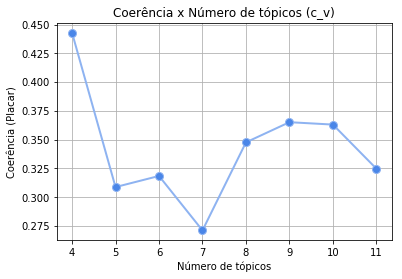

In [12]:
plt.plot(lsa_num_topics_values, lsa_coherence_values, color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_v)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.show()

In [13]:
lsa_models[0].print_topics(num_topics=4, num_words=6)
lsa_models[2].print_topics(num_topics=6, num_words=6)

[(0,
  '-0.451*"ahmed" + -0.390*"prime" + -0.373*"minister" + -0.334*"ethiopia" + -0.305*"ethiopian" + -0.177*"awarded"'),
 (1,
  '0.347*"greta" + 0.254*"win" + -0.245*"prime" + -0.230*"minister" + 0.213*"thunberg" + 0.202*"one"'),
 (2,
  '0.517*"greta" + 0.345*"thunberg" + -0.280*"awarded" + -0.275*"literature" + -0.223*"handke" + -0.219*"peter"'),
 (3,
  '-0.351*"greta" + -0.302*"via" + 0.297*"pr" + -0.259*"awarded" + -0.245*"thunberg" + -0.242*"literature"'),
 (4,
  '-0.601*"pr" + 0.495*"ethiopia" + -0.252*"prime" + -0.237*"minister" + 0.206*"pm" + -0.191*"ethiopian"'),
 (5,
  '-0.587*"pr" + -0.260*"pm" + 0.258*"prime" + 0.247*"minister" + -0.227*"ethiopia" + -0.181*"literature"')]

### Coherence model for LDA

In [14]:
from gensim.models.ldamulticore import LdaMulticore

In [15]:
%%time
num_topics_values = range(4, 20)
models = []
coherence_values = {
    'u_mass': [],
    'c_v': [],
    'c_uci': [],
    'c_npmi': []
}

for num_topics in num_topics_values:
    model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=num_topics, 
                                       id2word=dictionary,                                    
                                       passes=20,
                                       workers=5,
                                       iterations=400)
    models.append(model)
        
    u_mass_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='u_mass')
    coherence_values['u_mass'].append(u_mass_coherence_model.get_coherence())

    c_v_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_v')
    coherence_values['c_v'].append(c_v_coherence_model.get_coherence())
    
    c_uci_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_uci')
    coherence_values['c_uci'].append(c_uci_coherence_model.get_coherence())
    
    c_npmi_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_npmi')
    coherence_values['c_npmi'].append(c_npmi_coherence_model.get_coherence())

CPU times: user 5min 50s, sys: 26.2 s, total: 6min 16s
Wall time: 5min 59s


### Graph plotting

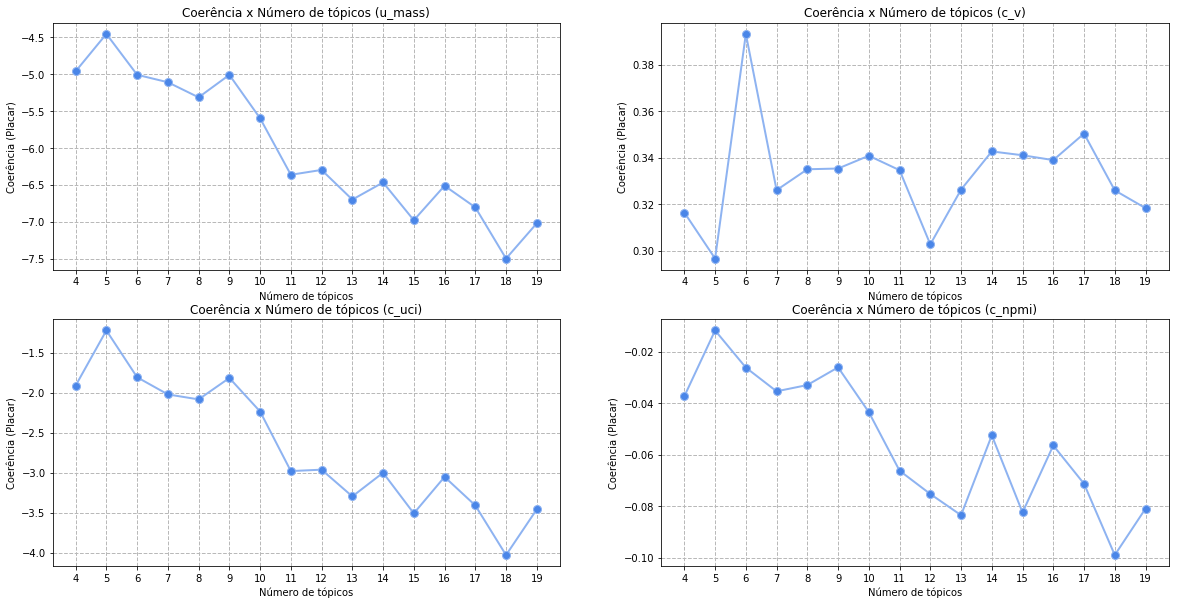

In [16]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['u_mass'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (u_mass)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,2)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_v'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_v)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,3)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_uci'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_uci)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,4)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_npmi'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_npmi)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 


plt.show() 

### Model visualization

In [17]:
import pyLDAvis.gensim

In [21]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(models[2], bow_corpus, dictionary, sort_topics=False)

/home/matheus/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.230482 -0.019288       1        1  11.778111
1      0.116249  0.264875       2        1  16.597548
2      0.107940 -0.050759       3        1  18.423388
3      0.130573 -0.149295       4        1  21.686405
4     -0.254314  0.011301       5        1  13.492206
5      0.130034 -0.056833       6        1  18.022337, topic_info=     Category         Freq             Term        Total  loglift  logprob
0     Default  1253.000000            ahmed  1253.000000  30.0000  30.0000
149   Default   993.000000         ethiopia   993.000000  29.0000  29.0000
135   Default   859.000000            prime   859.000000  28.0000  28.0000
132   Default   795.000000        ethiopian   795.000000  27.0000  27.0000
133   Default   812.000000         minister   812.000000  26.0000  26.0000
82    Default  1091.000000               pr  1091.000000  25.0000  25.0000
25    Default   520.000000       literature   520.000000  24.0000  24.0000
50    Default   769.000000            greta   769.000000  23.0000  23.0000
52    Default   415.000000         thunberg   415.000000  22.0000  22.0000
148   Default   411.000000          eritrea   411.000000  21.0000  21.0000
6     Default   571.000000               pm   571.000000  20.0000  20.0000
397   Default   432.000000             wins   432.000000  19.0000  19.0000
324   Default   395.000000           handke   395.000000  18.0000  18.0000
15    Default   295.000000        chemistry   295.000000  17.0000  17.0000
41    Default   343.000000            peter   343.000000  16.0000  16.0000
22    Default   393.000000  congratulations   393.000000  15.0000  15.0000
197   Default   519.000000              via   519.000000  14.0000  14.0000
27    Default   436.000000            obama   436.000000  13.0000  13.0000
57    Default   185.000000         conflict   185.000000  12.0000  12.0000
44    Default   226.000000        rejection   226.000000  11.0000  11.0000
61    Default   701.000000              get   701.000000  10.0000  10.0000
94    Default   558.000000           people   558.000000   9.0000   9.0000
760   Default   201.000000          efforts   201.000000   8.0000   8.0000
120   Default   736.000000          awarded   736.000000   7.0000   7.0000
915   Default   293.000000            price   293.000000   6.0000   6.0000
47    Default   203.000000           letter   203.000000   5.0000   5.0000
287   Default   239.000000              ali   239.000000   4.0000   4.0000
192   Default   226.000000          physics   226.000000   3.0000   3.0000
16    Default   178.000000              ion   178.000000   2.0000   2.0000
66    Default   409.000000            trump   409.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
514    Topic6    49.380878             wait    56.502735   1.5788  -5.7805
229    Topic6    79.047363            thank    97.566635   1.5031  -5.3100
131    Topic6    89.150490             week   113.629738   1.4709  -5.1897
162    Topic6   184.081329           prizes   265.464233   1.3475  -4.4647
191    Topic6    42.927284          already    48.776966   1.5858  -5.9206
1031   Topic6    39.651100          twitter    44.874607   1.5898  -6.0000
673    Topic6    72.095238            media    91.592560   1.4742  -5.4021
226    Topic6    66.357849             tiny    84.110474   1.4765  -5.4850
501    Topic6    49.295147             show    58.929665   1.5350  -5.7822
117    Topic6   173.742493        president   298.066986   1.1738  -4.5225
205    Topic6   192.214111            years   347.918762   1.1202  -4.4215
144    Topic6   146.150894              war   271.416779   1.0945  -4.6954
10     Topic6   226.507187           winner   567.287231   0.7955  -4.2573
27     Topic6   180.056366            obama   436.375488   0.8283  -4.4868
339    Topic6   130.807861             also   283.513916   0.9400  -4.8063


## Script

In [49]:
from topic_segmentation.get_topics import get_topics

In [54]:
lda_topics = get_topics('nobel', '../datasets/topic_segmentation', method='lda', count=6)
lda_topics

Time to clean up: 3.85 sec


[['committee',
  'greta',
  'help',
  'pr',
  'thunberg',
  'via',
  'win',
  'work',
  'world',
  'would'],
 ['ahmed',
  'awarded',
  'congratulations',
  'eritrea',
  'ethiopia',
  'ethiopian',
  'minister',
  'pm',
  'prime',
  'wins'],
 ['get', 'news', 'one', 'person', 'power', 'price', 'two', 'us', 'via', 'win'],
 ['chemistry',
  'first',
  'genocide',
  'ion',
  'laureate',
  'literature',
  'lithium',
  'no',
  'prizes',
  'year'],
 ['handke',
  'letter',
  'peter',
  'pr',
  'rejected',
  'rejection',
  'win',
  'winner',
  'winning',
  'work'],
 ['climate',
  'get',
  'got',
  'like',
  'no',
  'obama',
  'one',
  'people',
  'pr',
  'trump']]

In [53]:
lsa_topics = get_topics('nobel', '../datasets/topic_segmentation', method='lsa', count=6)
lsa_topics

Time to clean up: 3.91 sec


[['ahmed',
  'awarded',
  'ethiopia',
  'ethiopian',
  'minister',
  'pm',
  'pr',
  'prime'],
 ['greta', 'minister', 'no', 'one', 'pr', 'prime', 'thunberg', 'win'],
 ['awarded',
  'greta',
  'handke',
  'literature',
  'peter',
  'pr',
  'price',
  'thunberg'],
 ['awarded',
  'ethiopia',
  'greta',
  'handke',
  'literature',
  'pr',
  'thunberg',
  'via'],
 ['ahmed', 'ethiopia', 'ethiopian', 'minister', 'pm', 'pr', 'prime', 'winner'],
 ['ethiopia', 'handke', 'literature', 'minister', 'one', 'pm', 'pr', 'prime']]